                            OLS Regression Results                            
Dep. Variable:         Q("% Dødfisk")   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     66.50
Date:                Fri, 02 May 2025   Prob (F-statistic):           7.16e-86
Time:                        15:51:00   Log-Likelihood:                -884.42
No. Observations:                1886   AIC:                             1785.
Df Residuals:                    1878   BIC:                             1829.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

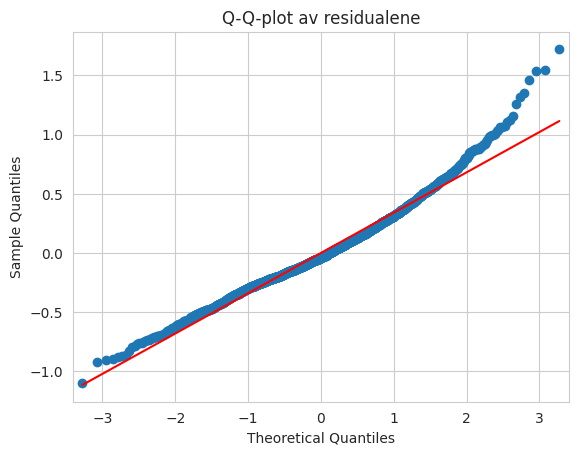

In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import matplotlib.pyplot as plt

# 1) Laste inn data
df = pd.read_csv('/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/summary_statistics.csv', sep=';')

# 2) Konverter dato og lag måned (hvis ikke allerede gjort)
df['Dato'] = pd.to_datetime(df['Dato'], errors='coerce')
df = df.dropna(subset=['Dato'])
df['måned'] = df['Dato'].dt.to_period('M')

# 3) Lag lagget rensefisk-variabel (per PO)
df = df.sort_values(['PO', 'måned'])
df['% Rensefisk_lag1'] = df.groupby('PO')['% Rensefisk'].shift(0)

#+ Q("% Rensefisk_lag1")

# 4) Enkel OLS (uten faste effekter)
model = smf.ols('Q("% Dødfisk") ~ Q("Temperaturee") + Q("badebehandling") + Q("mekanisk behandling") + Q("termisk behandling") + Q("Tetthet") + Q("BA_ano") + Q("% FORFORBRUK")', data=df)
result = model.fit()
print(result.summary())

# 5) Faste effekter (PO)
model_fe = smf.ols('Q("% Dødfisk") ~ Q("Temperatureee") +Q("% Rensefisk_lag1") + Q("badebehandling") + Q("mekanisk behandling") + Q("termisk behandling") + Q("Tetthet") + Q("BA_ano") + Q("% FORFORBRUK") + C(PO)', data=df)
result_fe = model_fe.fit()
print(result_fe.summary())










# 6) VIF-sjekk
X = result_fe.model.exog
vif_values = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print('VIF-verdier:')
for i, name in enumerate(result_fe.model.exog_names):
    print(f'{name}: {vif_values[i]:.2f}')

# 7) Breusch-Pagan test
bp_test = het_breuschpagan(result_fe.resid, X)
print(f'Breusch-Pagan p-verdi: {bp_test[1]:.4f}')

# 8) Q-Q-plot
sm.qqplot(result_fe.resid, line='s')
plt.title('Q-Q-plot av residualene')
plt.show()





In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Stilt oppsett som i eksempelet ditt
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 100
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Lato", "DejaVu Sans", "Arial"]

plt.figure(figsize=(16, 8))

#hent data fra csv
df = pd.read_csv('/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/summary_statistics.csv', sep=';')


df_total = df.copy()


def po_gruppe(po):
    if 1 <= po <= 4:
        return "PO 1-4"
    elif 5 <= po <= 8:
        return "PO 5-8"
    elif 9 <= po <= 13:
        return "PO 9-13"
    else:
        return "Annet"

df_total["PO_gruppe"] = df_total["PO"].astype(float).apply(po_gruppe)

# Scatterplot med farger etter PO-gruppe
ax = sns.scatterplot(
    data=df_total,
    x="Temperature",
    y="% Dødfisk",
    hue="PO_gruppe",
    palette=["tab:blue", "tab:orange", "tab:green"],
    alpha=0.7,
    s=60,
    edgecolor="white",
    linewidth=0.5
)
# legg til trendlinje for hver PO-gruppe
for po_group in df_total["PO_gruppe"].unique():
    group_data = df_total[df_total["PO_gruppe"] == po_group]
    sns.regplot(
        data=group_data,
        x="Temperature",
        y="% Dødfisk",
        scatter=False,
        ax=ax,
        line_kws={"color": "black", "alpha": 0.5, "linestyle": "--"},
        label=f"Trendlinje {po_group}"
    )



# Titler og akser
ax.set_title("% dødfisk som funksjon av havtemperatur", fontsize=18, fontweight="bold", pad=15)
ax.set_xlabel("Temperature (°C)", fontsize=13)
ax.set_ylabel("% dødfisk", fontsize=13)
ax.legend(title="Produksjonsområde (PO)", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.suptitle("")  # Fjerner automatisk over-overskrift

# Signatur og layout
plt.figtext(
    0.99, 0.01,
    "Kilde rådata: Fiskeridirektoratet og havforskningsinstituttet",
    ha="right",
    va="bottom",
    fontsize=12,
    alpha=0.5
)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Filtrer til kun PO 1
df_po1 = df_total[df_total["PO"] == 1]

# Scatterplot for kun PO 1
ax = sns.scatterplot(
    data=df_po1,
    x="Temperature",
    y="% Dødfisk",
    color="tab:blue",
    alpha=0.7,
    s=60,
    edgecolor="white",
    linewidth=0.5
)

ax.set_title("% dødfisk som funksjon av havtemperatur (PO 1)", fontsize=18, fontweight="bold", pad=15)
ax.set_xlabel("Temperature (°C)", fontsize=13)
ax.set_ylabel("% dødfisk", fontsize=13)
ax.legend([],[], frameon=False)  # Skjul legend

plt.suptitle("")
plt.figtext(
    0.99, 0.01,
    "Kilde rådata: Fiskeridirektoratet og havforskningsinstituttet",
    ha="right",
    va="bottom",
    fontsize=13,
    alpha=0.5
)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


NameError: name 'pd' is not defined

<Figure size 1600x800 with 0 Axes>

In [2]:
from linearmodels.panel import PanelOLS
import pandas as pd
#modell med tidsfikspunkta, vi må prøve å se litt mer om vi treng detta...
# Lag 'ÅrMnd' som tidskategori
df['ÅrMnd'] = df['måned'].dt.to_period('M').astype(str)

# Gjør om 'ÅrMnd' til kategorisk variabel for fixed effects
df['ÅrMnd'] = pd.Categorical(df['ÅrMnd'])

# Lag multiindeks: PO og måned
panel_df = df.set_index(['PO', 'måned'])

# Lag dummier for tidspunktene (ÅrMnd)
dummies_tid = pd.get_dummies(panel_df['ÅrMnd'], drop_first=True)

# Forklaringsvariabler
exog = pd.concat([
    panel_df[['Temperature', 'rensefisk', 'behandling1', 'behandling2']],
    dummies_tid
], axis=1)

# PanelOLS med både PO-faste effekter og tidspunktsdummier
mod = PanelOLS(panel_df['dodelighet'], exog, entity_effects=True)
res = mod.fit()
print(res.summary)


ModuleNotFoundError: No module named 'linearmodels'

In [3]:
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

# Importer data
df = pd.read_csv('data/processed/summary_statistics.csv', sep=';')

# Konverter dato og lag måned hvis ikke allerede gjort
df['Dato'] = pd.to_datetime(df['Dato'], errors='coerce')
df = df.dropna(subset=['Dato'])
df['måned'] = df['Dato'].dt.to_period('M')

# Lag lagget rensefisk-variabel (per PO)
df = df.sort_values(['PO', 'måned'])
df['% Rensefisk_lag1'] = df.groupby('PO')['% Rensefisk'].shift(1)

# Nå kan du droppe rader med NaN i relevante kolonner
relevante_kolonner = [
    "% Dødfisk", "Temperature", "Tetthet", "BA_ano", "% FORFORBRUK",
    "% Rensefisk_lag1", "badebehandling", "mekanisk behandling", "termisk behandling", "PO", "% Rensefisk"
]
df = df.dropna(subset=relevante_kolonner)

# Lag kvadrert temperaturvariabel
df["Temperatur2"] = df["Temperature"]**2

# Modellformler med originale variabelnavn og faste effekter for PO
f1 = 'Q("% Dødfisk") ~ Q("Temperature") + C(PO)'
f2 = 'Q("% Dødfisk") ~ Q("Temperature") + Q("Tetthet") + Q("BA_ano") + Q("% FORFORBRUK") + C(PO)'
f3 = 'Q("% Dødfisk") ~ Q("Temperature") + Q("Tetthet")+ Temperatur2  + Q("BA_ano") + Q("% FORFORBRUK") + C(PO)'
f4 = 'Q("% Dødfisk") ~ Q("Temperature") + Q("Tetthet")+ Temperatur2  + Q("BA_ano") + Q("% FORFORBRUK") + Q("% Rensefisk_lag1") + Q("badebehandling") + Q("mekanisk behandling") + Q("termisk behandling") + C(PO)'

# Estimer modellene
model1 = smf.ols(f1, data=df).fit(cov_type='HC3')
model2 = smf.ols(f2, data=df).fit(cov_type='HC3')
model3 = smf.ols(f3, data=df).fit(cov_type='HC3')
model4 = smf.ols(f4, data=df).fit(cov_type='HC3')

# Lag samlet tabell
summary = summary_col(
    [model1, model2, model3, model4],
    stars=True,
    float_format='%0.4f',
    model_names=["(1)", "(2)", "(3)", "(4)"],
    info_dict={
        'R-squared': lambda x: f"{x.rsquared:.3f}",
        'N': lambda x: f"{int(x.nobs)}"
    },
    regressor_order=[
        'Intercept',
        'Q("Temperature")',
        'Q("Tetthet")',
        'Q("BA_ano")',
        'Q("% FORFORBRUK")',
        'Temperatur2',
        'Q("% Rensefisk_lag1")',
        'Q("badebehandling")',
        'Q("mekanisk behandling")',
        'Q("termisk behandling")',
        'C(PO)[T.1.0]',
        'C(PO)[T.2.0]',
        'C(PO)[T.3.0]',
        'C(PO)[T.4.0]',
        'C(PO)[T.5.0]',
        'C(PO)[T.6.0]',
        'C(PO)[T.7.0]',
        'C(PO)[T.8.0]',
        'C(PO)[T.9.0]',
        'C(PO)[T.10.0]',
        'C(PO)[T.11.0]',
        'C(PO)[T.12.0]',
        'C(PO)[T.13.0]',
    ]
)

print(summary)
# Lagre tabellen som LaTeX
with open('/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/modell_2017.tex', 'w') as f:
    f.write(summary.as_latex())

# 6) VIF-sjekk
X = result_fe.model.exog
vif_values = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print('VIF-verdier:')
for i, name in enumerate(result_fe.model.exog_names):
    print(f'{name}: {vif_values[i]:.2f}')

# 7) Breusch-Pagan test
bp_test = het_breuschpagan(result_fe.resid, X)
print(f'Breusch-Pagan p-verdi: {bp_test[1]:.4f}')

# 8) Q-Q-plot
sm.qqplot(result_fe.resid, line='s')
plt.title('Q-Q-plot av residualene')
plt.show()


                            (1)        (2)        (3)        (4)    
--------------------------------------------------------------------
Intercept                0.8474***  0.8975***  1.0392***  1.0387*** 
                         (0.0512)   (0.0530)   (0.0749)   (0.0757)  
Q("Temperature")         0.0091***  0.0650***  0.0103     0.0182    
                         (0.0028)   (0.0070)   (0.0193)   (0.0193)  
Q("Tetthet")                        0.0273***  0.0286***  0.0248*** 
                                    (0.0052)   (0.0052)   (0.0052)  
Q("BA_ano")                         -0.0346*** -0.0273*** -0.0239** 
                                    (0.0097)   (0.0099)   (0.0100)  
Q("% FORFORBRUK")                   -0.0367*** -0.0309*** -0.0336***
                                    (0.0035)   (0.0039)   (0.0039)  
Temperatur2                                    0.0023***  0.0019**  
                                               (0.0008)   (0.0008)  
Q("% Rensefisk_lag1")            

NameError: name 'result_fe' is not defined

In [8]:
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

#modell med

# Importer data
df = pd.read_csv('/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/summary_statistics_2017.csv', sep=';')
print(df.columns.tolist())
df.columns = df.columns.str.strip()
# Konverter dato og lag måned hvis ikke allerede gjort
df['Dato'] = pd.to_datetime(df['Dato'], errors='coerce')
df = df.dropna(subset=['Dato'])
df['måned'] = df['Dato'].dt.to_period('M')

# Lag lagget rensefisk-variabel (per PO)
df = df.sort_values(['PO', 'måned'])
df['% Rensefisk_lag1'] = df.groupby('PO')['% Rensefisk'].shift(1)
df['Temperature'] = df.groupby('PO')['Temperature'].shift(0)

# Nå kan du droppe rader med NaN i relevante kolonner
relevante_kolonner = [
    "% Dødfisk", "Temperature", "Tetthet", "BA_ano", "% FORFORBRUK",
    "% Rensefisk_lag1", "badebehandling", "mekanisk behandling", "termisk behandling", "PO", "% Rensefisk"
]
df = df.dropna(subset=relevante_kolonner)

# Lag kvadrert temperaturvariabel
df["Temperatur2"] = df["Temperature"]**2

# Modellformler med originale variabelnavn og faste effekter for PO
f1 = 'Q("% Dødfisk") ~ Q("Temperature") + C(PO)'
f2 = 'Q("% Dødfisk") ~ Q("Temperature") + Q("Tetthet") + Q("BA_ano") + Q("% FORFORBRUK") + C(PO)'
f3 = 'Q("% Dødfisk") ~ Q("Temperature") + Q("Tetthet")+ Temperatur2  + Q("BA_ano") + Q("% FORFORBRUK") + C(PO)'
f4 = 'Q("% Dødfisk") ~ Q("Temperature") + Q("Tetthet")+ Temperatur2  + Q("BA_ano") + Q("% FORFORBRUK") + Q("% Rensefisk_lag1") + Q("badebehandling") + Q("mekanisk behandling") + Q("termisk behandling") + C(PO)'

# Estimer modellene
model1 = smf.ols(f1, data=df).fit(cov_type='HC3')
model2 = smf.ols(f2, data=df).fit(cov_type='HC3')
model3 = smf.ols(f3, data=df).fit(cov_type='HC3')
model4 = smf.ols(f4, data=df).fit(cov_type='HC3')

# Lag samlet tabell
summary = summary_col(
    [model1, model2, model3, model4],
    stars=True,
    float_format='%0.4f',
    model_names=["(1)", "(2)", "(3)", "(4)"],
    info_dict={
        'R-squared': lambda x: f"{x.rsquared:.3f}",
        'N': lambda x: f"{int(x.nobs)}"
    },
    regressor_order=[
        'Intercept',
        'Q("Temperature")',
        'Q("Tetthet")',
        'Q("BA_ano")',
        'Q("% FORFORBRUK")',
        'Temperatur2',
        'Q("% Rensefisk_lag1")',
        'Q("badebehandling")',
        'Q("mekanisk behandling")',
        'Q("termisk behandling")',
        'C(PO)[T.1.0]',
        'C(PO)[T.2.0]',
        'C(PO)[T.3.0]',
        'C(PO)[T.4.0]',
        'C(PO)[T.5.0]',
        'C(PO)[T.6.0]',
        'C(PO)[T.7.0]',
        'C(PO)[T.8.0]',
        'C(PO)[T.9.0]',
        'C(PO)[T.10.0]',
        'C(PO)[T.11.0]',
        'C(PO)[T.12.0]',
        'C(PO)[T.13.0]',
    ]
)

print(summary)
# Lagre tabellen som LaTeX
with open('/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/modell_2012.tex', 'w') as f:
    f.write(summary.as_latex())


['Unnamed: 0', 'Dato', 'PO', 'Temperature', '% Dødfisk', 'Tetthet', 'BA_ano', '% FORFORBRUK', '% Rensefisk', 'badebehandling', 'ferskvannsbehandling', 'fôrbehandling', 'mekanisk behandling', 'termisk behandling']

                            (1)        (2)        (3)        (4)    
--------------------------------------------------------------------
Intercept                0.8750***  0.9736***  1.0579***  1.0539*** 
                         (0.0790)   (0.0818)   (0.1119)   (0.1107)  
Q("Temperature")         -0.0160*** 0.0341***  0.0022     0.0025    
                         (0.0039)   (0.0098)   (0.0289)   (0.0286)  
Q("Tetthet")                        0.0391***  0.0408***  0.0347*** 
                                    (0.0086)   (0.0088)   (0.0086)  
Q("BA_ano")                         -0.0411*** -0.0364**  -0.0282** 
                                    (0.0135)   (0.0144)   (0.0144)  
Q("% FORFORBRUK")                   -0.0342*** -0.0310*** -0.0328***
                           